## Jupyter Notebook for overview

For exact instructions and required packages to download to run the git repo, refer Readme - detailed instructions and step by step procedure is listed there. 


In [ ]:
#Filename -> main.py 


#
# main entry point of our program
#
# Nov 20, 2018 by Renjie Zhu
# 

from scripts.process_data import process_data
import logging
import os

logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

assert not os.path.exists(os.path.join('processed_data','school.db')), 'School data has already been processed. Go next step or delete school.db to reproduce the data!'
process_data('school')
assert not os.path.exists(os.path.join('processed_data','industry.db')), 'Industry data has already been processed. Go next step or delete industry.db to reproduce the data!'
process_data('industry')

import analyze_data
import analyze_data_by_department
import merge_industry

logger.info('Program ends.')



# Use the following to plot the required graphs

All the following cells are independent of each other and just require the above cell to be executed.

## Extent of Overlap Venn diagram

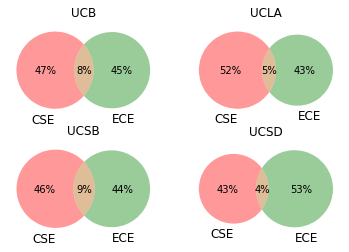

In [1]:
#Filename -> Plot_Extent_of_overlap.py

#
# Visualization part 3 
# Script that deals with Extent of overlap, using Venn Diagrams 
#
# Nov 25, 2018 by Ambareesh S J
# 
#
%matplotlib inline
import pandas as pd
import itertools as it
from matplotlib_venn import venn2,venn3
import matplotlib.pyplot as plt
from matplotlib.pylab import subplots
import os

def make_venn_diagram(set_a,set_b,title_of_plot='UCSD'):
	'''
	Purpose : Function that creates a venn diagram representation of ECE and CSE Departments and portrays the extent of overlap between them
	
	Inputs : set_a
			 set_b 
			 (set)
			 Input sets which are the departments whose overlap you want to plot using a venn diagram
			 
			 title_of_plot
			 (str)
			 Title of the venn diagram, default value - "UCSD"
	
	Output : VennDiagram object to plot
	
	'''
	assert isinstance(set_a,set),"Inputs should be set objects"
	assert isinstance(set_b,set),"Inputs should be set objects"
	assert isinstance(title_of_plot,str),"Title should be a valid string"

	labels_depts=['CSE','ECE']
	total = len(set_a.union(set_b))
	v1 = venn2([set_a,set_b],set_labels=labels_depts,set_colors=['red','green'],subset_label_formatter=lambda x: f"{(x/total):1.0%}")
	plt.title(title_of_plot)
	return v1

plt.subplot(221) #making 2*2 subplots for 4 different plots (4 universities)
df1=pd.read_excel(os.path.join('processed_data','ucberkeley_cs.xlsx'),usecols='A')
cse_set_ucb = set(list(it.chain.from_iterable(df1.values.tolist())))
df2 = pd.read_excel(os.path.join('processed_data','ucberkeley_ee.xlsx'),usecols='A')
ece_set_ucb = set(list(it.chain.from_iterable(df2.values.tolist())))
make_venn_diagram(cse_set_ucb,ece_set_ucb,title_of_plot='UCB')

plt.subplot(222)
df1=pd.read_excel(os.path.join('processed_data','ucla_cse.xlsx'),usecols='A')
cse_set_ucla = set(list(it.chain.from_iterable(df1.values.tolist())))
df2 = pd.read_excel(os.path.join('processed_data','ucla_ece.xlsx'),usecols='A')
ece_set_ucla = set(list(it.chain.from_iterable(df2.values.tolist())))
make_venn_diagram(cse_set_ucla,ece_set_ucla,title_of_plot='UCLA')

plt.subplot(223)
df1=pd.read_excel(os.path.join('processed_data','ucsb_cse.xlsx'),usecols='A')
cse_set_ucsb = set(list(it.chain.from_iterable(df1.values.tolist())))
df2 = pd.read_excel(os.path.join('processed_data','ucsb_ece.xlsx'),usecols='A')
ece_set_ucsb = set(list(it.chain.from_iterable(df2.values.tolist())))
make_venn_diagram(cse_set_ucsb,ece_set_ucsb,title_of_plot='UCSB')

plt.subplot(224)
df1=pd.read_excel(os.path.join('processed_data','ucsd_cse.xlsx'),usecols='A')
cse_set_ucsd = set(list(it.chain.from_iterable(df1.values.tolist())))
df2 = pd.read_excel(os.path.join('processed_data','ucsd_ece.xlsx'),usecols='A')
ece_set_ucsd= set(list(it.chain.from_iterable(df2.values.tolist())))
make_venn_diagram(cse_set_ucsd,ece_set_ucsd,title_of_plot='UCSD')

plt.show()

## Radar chart

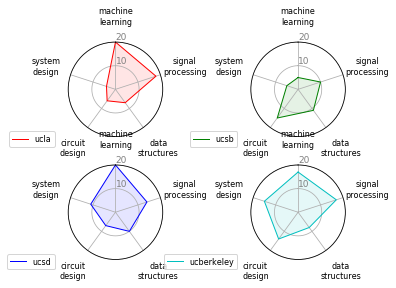

In [2]:
#Filename -> Plot_radar_chart.py

# This script connect industry hot topics with universities
# We got Industry_words.txt which is analyzed using the script analyze_data_merge_industry.py
# Then this script checks if the words from Industry_words.txt has frequency in Universities'
# catalog. Which produce a excel file industry_connection.xlsx
# Strat from line 91, we used analyzed excel sheet to finde the hot topics
# which has data from all the four universities.
# Radar chart is drawn by using matplotlib.
# By Daoyu Li
%matplotlib inline
import os
import sqlite3
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

industry_words = []
with open(os.path.join('scripts', 'Industry_words.txt'), 'rt') as f:
    for line in f.readlines():
        industry_words.append(line.strip('\n'))
df_rowindex = industry_words
with sqlite3.connect(os.path.join('processed_data','Analyzed_data.db')) as con:
    cursor = con.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tablename = cursor.fetchall()
    tablename = list(map(lambda i: i[0].split('_'), tablename))
    school_list = []
    for name in tablename:
        #name[0] is school, name[1] is department
        school_list.append(name[0])
    school_list = list(set(school_list))
    df_columnindex = school_list
    freq_array = np.zeros([len(industry_words), len(school_list)])
    for iword in industry_words:
        for school in school_list:
            # Due to raw data file name provided by Fernando,
            # Some condition assignment should be placed :(
            if school == 'ucberkeley':
                ece = 'ee'
                cse = 'cs'
            else:
                ece = 'ece'
                cse = 'cse'
            df_ece = pd.read_sql_query(
                "SELECT * FROM "+str('_'.join([school, ece])), con=con)
            df_cse = pd.read_sql_query(
                "SELECT * FROM "+str('_'.join([school, cse])), con=con)
            for bigram in df_cse['index']:
                if iword in bigram:
                    df_index = list(df_cse['index']).index(bigram)
                    freq_array[industry_words.index(iword), school_list.index(school)] = freq_array[industry_words.index(
                        iword), school_list.index(school)]+df_cse['18'][df_index]
            for bigram in df_ece['index']:
                if iword in bigram:
                    df_index = list(df_ece['index']).index(bigram)
                    freq_array[industry_words.index(iword), school_list.index(school)] = freq_array[industry_words.index(
                        iword), school_list.index(school)]+df_ece['18'][df_index]
df = pd.DataFrame(freq_array, df_rowindex, df_columnindex)
df.to_excel(os.path.join('processed_data','industry_connection.xlsx'), sheet_name='result')
# We examine the output excel file to find the five hot topics which have frequency overlap among
# four universities.
# Then we have the subject_list to draw the radar chart
subject_list = ['machine learning', 'signal processing', 'data structures', 'circuit design',
                'system design']
df = df.loc[subject_list]

# Draw radar chart
# number of variable
categories = ['\n'.join(word.split(' ')) for word in subject_list]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
size = len(school_list)
# Four schools' color
colormap = ['r', 'g', 'b', 'c']


def draw_radar_chart(n, values):
    ax = plt.subplot(2, 2, n+1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories, fontsize=8)
    # Offset the subject words
    ax.tick_params(direction='out', pad=15)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10, 20, 30], ["10", "20", "30"], color="grey", size=9)
    # Limit of the outter circle
    plt.ylim(0, 20)
    # Plot&Fill radar chart
    ax.plot(angles, values,
            color=colormap[i], linewidth=1, linestyle='solid', label=school_list[i])
    ax.fill(angles, values, colormap[i], alpha=0.1)
    plt.legend(loc='upper right', bbox_to_anchor=(-0.1, 0.1), fontsize=8)


for i in range(len(school_list)):
    values = df[school_list[i]].values.flatten().tolist()
    values += values[:1]
    draw_radar_chart(i, values)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=None, hspace=0.3)
plt.show()


## UCSD CSE complete Line graph plot

(0, 18)

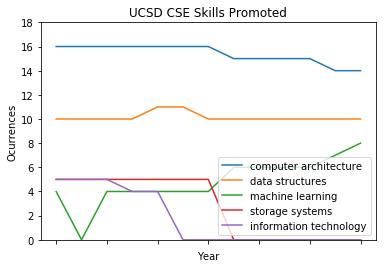

In [3]:
#Filename -> Plot_ucsd_ece.py

# ECE 143 Engineering Course Analysis
# Plots of selected catalog topics from the UCSD CSE Department
#
# matplotlib ONLY version, WORK IN PROGRESS
# python and plotly used for presentation
#
# By Fernando Lopez
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
# Department to analyze
department = 'ucsd_cse'

# keywords to analyze
keyword0 = 'computer architecture'
keyword1 = 'data structures'
keyword2 = 'machine learning'
keyword3 = 'storage systems'
keyword4 = 'information technology'

# Read excel file into a Data Frame
cse_df = pd.read_excel(os.path.join('processed_data',department + '.xlsx'))

# Plot the ocurrences of the selected keywords
cse_df.loc[keyword0].plot()
cse_df.loc[keyword1].plot()
cse_df.loc[keyword2].plot()
cse_df.loc[keyword3].plot()
cse_df.loc[keyword4].plot()

plt.title("UCSD CSE Skills Promoted")
plt.xlabel('Year')
plt.ylabel('Ocurrences')
plt.legend([keyword0,keyword1,keyword2,keyword3,keyword4])
plt.ylim(0, 18)

(0, 18)

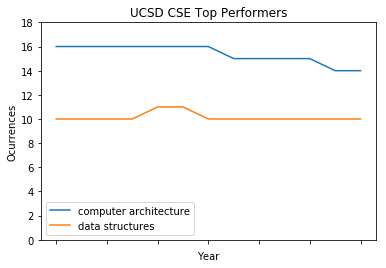

In [4]:
# Plot top performers
cse_df.loc[keyword0].plot()
cse_df.loc[keyword1].plot()

plt.title("UCSD CSE Top Performers")
plt.xlabel('Year')
plt.ylabel('Ocurrences')
plt.legend([keyword0,keyword1])
plt.ylim(0, 18)



(0, 18)

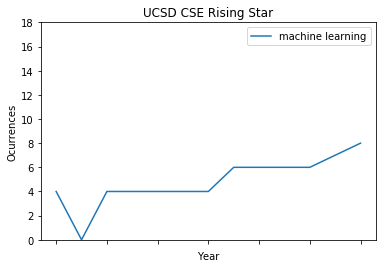

In [5]:
# Plot rising stars
cse_df.loc[keyword2].plot()

plt.title("UCSD CSE Rising Star")
plt.xlabel('Year')
plt.ylabel('Ocurrences')
plt.legend([keyword2])
plt.ylim(0, 18)

(0, 18)

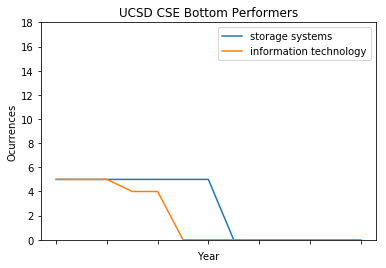

In [6]:
# Plot bottom performers
cse_df.loc[keyword3].plot()
cse_df.loc[keyword4].plot()

plt.title("UCSD CSE Bottom Performers")
plt.xlabel('Year')
plt.ylabel('Ocurrences')
plt.legend([keyword3,keyword4])
plt.ylim(0, 18)

## UCSD ECE complete line graph plot

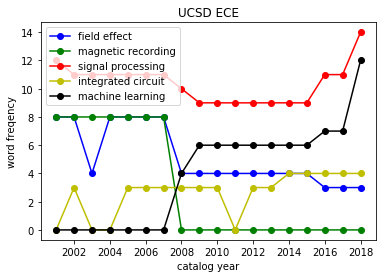

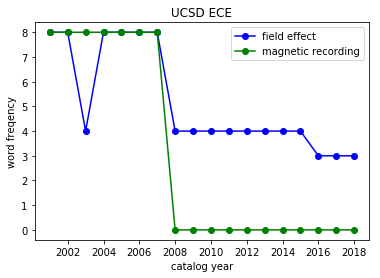

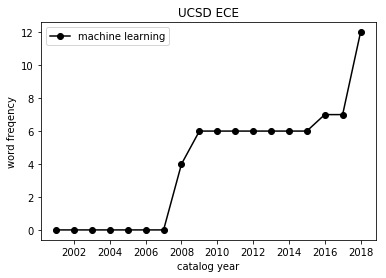

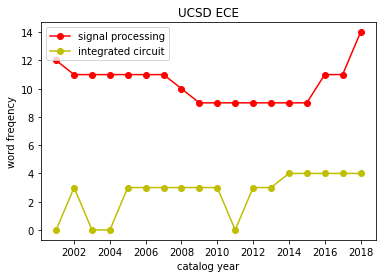

In [7]:
#Filename -> Plot_ucsd_ece.py

# -*- coding: utf-8 -*-
#
# Ploting graphs using matplotlib and plotly
# Trend of the ECE department at UCSD
#
# Nov 22, 2018 by Renjie Zhu
#

"""ucsd_ece_plot.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1cwTUqhwisEjNnQHy8TXDVHDeiD48ppBR
"""

%matplotlib inline

"""# Question:

How has the ECE departement evolved during the past 18 years.

What new words emerged? (Machine Learning)

What words died? (magnetic recording, field effect)

What remains its importance? (signal processing, integrated circuit)

# Use Matplotlib
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import os

# !pip install xlrd

ucsd_ece = pd.read_excel(os.path.join('processed_data','ucsd_ece.xlsx'))

field = ucsd_ece.loc['field effect']
magnetic = ucsd_ece.loc['magnetic recording']
signal = ucsd_ece.loc['signal processing']
integrated = ucsd_ece.loc['integrated circuit']
machine = ucsd_ece.loc['machine learning']

years = np.linspace(2001,2018, 18, dtype=np.int64)

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(years, field,'bo-')
ax.plot(years, magnetic,'go-')
ax.plot(years, signal,'ro-')
ax.plot(years, integrated,'yo-')
ax.plot(years, machine, 'ko-')
ax.set_ylabel('word freqency')
ax.set_xlabel('catalog year')
ax.set_title('UCSD ECE')
ax.legend()

fig.savefig(os.path.join('processed_data','all.jpg'))

fig2, ax2 = plt.subplots()
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.plot(years, field,'bo-')
ax2.plot(years, magnetic,'go-')
# ax.plot(years, signal,'ro-')
# ax.plot(years, integrated,'yo-')
# ax.plot(years, machine, 'ko-')
ax2.set_ylabel('word freqency')
ax2.set_xlabel('catalog year')
ax2.set_title('UCSD ECE')
ax2.legend()

fig2.savefig(os.path.join('processed_data','drop.jpg'))

fig3, ax3 = plt.subplots()
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax3.plot(years, field,'bo-')
# ax3.plot(years, magnetic,'go-')
# ax3.plot(years, signal,'ro-')
# ax3.plot(years, integrated,'yo-')
ax3.plot(years, machine, 'ko-')
ax3.set_ylabel('word freqency')
ax3.set_xlabel('catalog year')
ax3.set_title('UCSD ECE')
ax3.legend()

fig3.savefig(os.path.join('processed_data','incre.jpg'))

fig4, ax4 = plt.subplots()
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax4.plot(years, field,'bo-')
# ax4.plot(years, magnetic,'go-')
ax4.plot(years, signal,'ro-')
ax4.plot(years, integrated,'yo-')
# ax4.plot(years, machine, 'ko-')
ax4.set_ylabel('word freqency')
ax4.set_xlabel('catalog year')
ax4.set_title('UCSD ECE')
ax4.legend()

fig4.savefig(os.path.join('processed_data','flat.jpg'))



### Another approach using plotly to create the figure:

In [ ]:
"""# Additional Question:

Connection to the industry data.
"""
"""
# Using plotly

Using plotly may be another solution if visuals are more important.
"""

field_array = field.get_values()
magnetic_array = magnetic.get_values()
signal_array = signal.get_values()
integrated_array = signal.get_values()
machine_array = machine.get_values()

import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('johnsonlumia','Di2ueeMg6PKBCmw57HKn')

ma_tr = go.Scatter(
    x = years,
    y = machine_array,
    name = 'machine learning',
    mode = 'lines+markers',
)

fi_tr = go.Scatter(
    x = years,
    y = field_array,
    name = 'field effect',
    mode = 'lines+markers',
)

mg_tr = go.Scatter(
    x = years,
    y = magnetic_array,
    name = 'magnetic recording',
    mode = 'lines+markers',
)

si_tr = go.Scatter(
    x = years,
    y = signal_array,
    name = 'signal processing',
    mode = 'lines+markers',
)

in_tr = go.Scatter(
    x = years,
    y = integrated_array,
    name = 'integrated circuits',
    mode = 'lines+markers',
)

data = [ma_tr, fi_tr, mg_tr, si_tr, in_tr]
layout = {
  "title": "UCSD ECE Departmental Evolution", 
  "xaxis": {
    "autorange": False, 
    "range": [2000, 2019], 
    "title": "Year of Catalog", 
    "type": "linear"
  }, 
  "yaxis": {
    "autorange": False, 
    "range": [-0.5, 15], 
    "title": "Occurance", 
    "type": "linear"
  }
}
fig = go.Figure(data=data, layout=layout)
py.plot(fig)

## Departments comparason

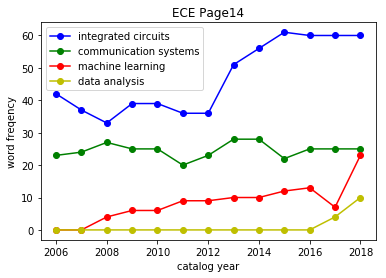

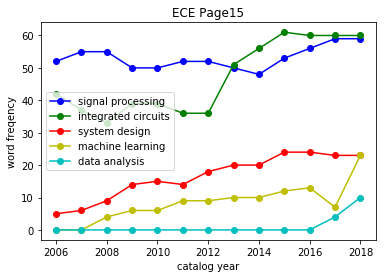

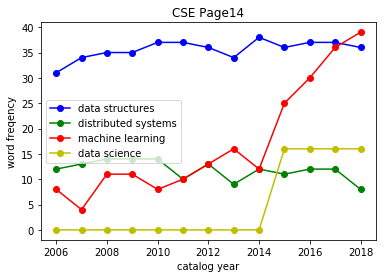

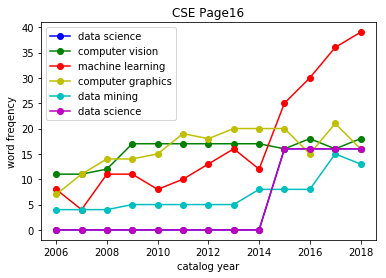

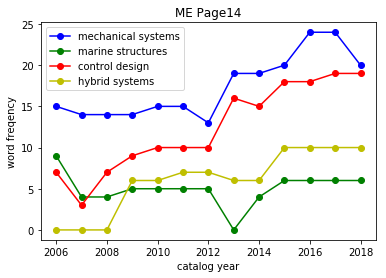

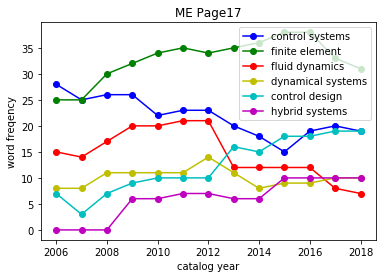

In [9]:
# This script is used to plot data from analysis
# Department by department
# Hard code is used for the topics has been choosen from the most
# frequently mentioned in the catalog
# !!!Plot data only script!!!
# By Daoyu Li
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import os
%matplotlib inline
# Page 14 ECE
df = pd.read_excel(os.path.join('processed_data','ece.xlsx'), index_col=0, usecols = "A:N")
integrated = df.loc['integrated circuits']
communication = df.loc['communication systems']
machine = df.loc['machine learning']
data_a = df.loc['data analysis']

years = np.linspace(2006,2018, 13, dtype=np.int64)

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(years, integrated,'bo-')
ax.plot(years, communication,'go-')
ax.plot(years, machine,'ro-')
ax.plot(years, data_a,'yo-')
ax.set_ylabel('word freqency')
ax.set_xlabel('catalog year')
ax.set_title('ECE Page14')
ax.legend()

fig.show()

# Page 15 ECE
df = pd.read_excel(os.path.join('processed_data','ece.xlsx'), index_col=0,usecols = "A:N")
sp = df.loc['signal processing']
ic = df.loc['integrated circuits']
sd = df.loc['system design']
ml = df.loc['machine learning']
da = df.loc['data analysis']
years = np.linspace(2006,2018, 13, dtype=np.int64)

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(years, sp,'bo-')
ax.plot(years, ic,'go-')
ax.plot(years, sd,'ro-')
ax.plot(years, ml,'yo-')
ax.plot(years, da,'co-')
ax.set_ylabel('word freqency')
ax.set_xlabel('catalog year')
ax.set_title('ECE Page15')
ax.legend()

fig.show()

# Page 14 CSE
df = pd.read_excel(os.path.join('processed_data','cse.xlsx'), index_col=0,usecols = "A:N")
data_structures = df.loc['data structures']
distributed = df.loc['distributed systems']
machine = df.loc['machine learning']
data_sci = df.loc['data science']

years = np.linspace(2006,2018, 13, dtype=np.int64)

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(years, data_structures,'bo-')
ax.plot(years, distributed,'go-')
ax.plot(years, machine,'ro-')
ax.plot(years, data_sci,'yo-')
ax.set_ylabel('word freqency')
ax.set_xlabel('catalog year')
ax.set_title('CSE Page14')
ax.legend()

fig.show()

# Page 16 CSE
df = pd.read_excel(os.path.join('processed_data','cse.xlsx'), index_col=0,usecols = "A:N")
ds = df.loc['data structures']
cv = df.loc['computer vision']
ml = df.loc['machine learning']
cg = df.loc['computer graphics']
dm = df.loc['data mining']
ds = df.loc['data science']

years = np.linspace(2006,2018, 13, dtype=np.int64)

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(years, ds,'bo-')
ax.plot(years, cv,'go-')
ax.plot(years, ml,'ro-')
ax.plot(years, cg,'yo-')
ax.plot(years, dm,'co-')
ax.plot(years, ds,'mo-')
ax.set_ylabel('word freqency')
ax.set_xlabel('catalog year')
ax.set_title('CSE Page16')
ax.legend()

fig.show()

# Page 14 ME
df = pd.read_excel(os.path.join('processed_data','me.xlsx'), index_col=0,usecols = "A:N")
ms = df.loc['mechanical systems']
marine = df.loc['marine structures']
cd = df.loc['control design']
hs = df.loc['hybrid systems']

years = np.linspace(2006,2018, 13, dtype=np.int64)

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(years, ms,'bo-')
ax.plot(years, marine,'go-')
ax.plot(years, cd,'ro-')
ax.plot(years, hs,'yo-')
ax.set_ylabel('word freqency')
ax.set_xlabel('catalog year')
ax.set_title('ME Page14')
ax.legend()

fig.show()

# Page 17 ME
df = pd.read_excel(os.path.join('processed_data','me.xlsx'), index_col=0,usecols = "A:N")
cs = df.loc['control systems']
fe = df.loc['finite element']
fd = df.loc['fluid dynamics']
ds = df.loc['dynamical systems']
cd = df.loc['control design']
hs = df.loc['hybrid systems']


years = np.linspace(2006,2018, 13, dtype=np.int64)

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(years, cs,'bo-')
ax.plot(years, fe,'go-')
ax.plot(years, fd,'ro-')
ax.plot(years, ds,'yo-')
ax.plot(years, cd,'co-')
ax.plot(years, hs,'mo-')
ax.set_ylabel('word freqency')
ax.set_xlabel('catalog year')
ax.set_title('ME Page17')
ax.legend()